In [1]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load Data from Bugzilla (REST)

Here's a link to the [Bugzilla URL for Papyrus](https://bugs.eclipse.org/bugs/buglist.cgi?bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED&limit=0&list_id=17376363&order=priority%2Cbug_severity&product=Papyrus&query_format=advanced) (filtered on open bugs):

First we need to request the data based on our Bugzilla query. The initial response will only include overall bug information, so to retrieve the full bug text (with comments), an additional request is made for each bug.

We'll create a few arrays of data based on the bugs:
1. bug_ids - the text id of the bug
2. bug_titles - the title of the bug
3. bug_products - the product listed for the bug
4. bug_components - the component listed for the bug
5. bug_text - a concatenation of all of the text (including comments) entered for the bug

# REST Data Loading

This piece loads JSON formated data through a http GET request and parses it into the arrays described previously.

In [ ]:
###
### Need to update this to pick up reporter and commenters
###
import requests

# Remove the limit=10 after debugging errors. Beware of rate limits. Eclipse Bugzilla automatically limits to 2000
resp = requests.get('https://bugs.eclipse.org/bugs/rest/bug?limit=10&product=Papyrus&bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

bugs = resp.json()
print('Loaded '+str(len(bugs['bugs']))+' bugs')


bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []
bug_reporter = []
bug_commenters = []

def getComments(id):
    url = 'https://bugs.eclipse.org/bugs/rest/bug/'+str(id)+'/comment'
    resp = requests.get(url)
    if resp.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    response = resp.json()
    
    text = ' '
    commenters = []
    for comment in response['bugs'][str(id)]['comments']:
        text += ' '+ comment['text']
    return text, commenters
    
for bug in bugs['bugs']:
    id = bug['id']
    bug_ids.append(id)
    
    summary = bug['summary']
    bug_titles.append(summary)
    product = bug['product']
    bug_products.append(product)
    
    component = bug['component']
    bug_components.append(component)
    
    text = summary + getComments(id)
    bug_text.append(text);    


# XML Data Loading

Another approach is to download an XML file from a Bugzilla query so that you don't have to connect to the server every time you run this notebook. It is good for debugging, but will need to switch back to a live connection any time you want to pick up new data.

A sample download is provided in the data/papyrus_bugs.xml file in the github repository.

In [2]:
import xml.etree.ElementTree as ET

bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []
bug_reporter = []
bug_commenters = []

filename = 'data/papyrus_bugs.xml'
tree = ET.parse(filename)
root = tree.getroot()
for bug in root:
    
    id = bug.find('bug_id')
    bug_ids.append(id.text)
    
    title = bug.find('short_desc')
    bug_titles.append(title.text)
    
    product = bug.find('product')
    bug_products.append(product.text)
    
    component = bug.find('component')
    bug_components.append(component.text)

    reporter = bug.find('reporter')
    bug_reporter.append(reporter.text)
    
    text = title.text
    for thetext in bug.iter('thetext'):
        if thetext.text:
            text += ' '+ thetext.text
            
    commenters = []
    for longdesc in bug.iter('long_desc'):
        commenter = longdesc.find('who')
        commenters.append(commenter.text)
        thetext = longdesc.find('thetext')
        if thetext.text:
            text += ' '+ thetext.text
    bug_text.append(text)
    bug_commenters.append(commenters)
    
print('Loaded '+str(len(bug_ids))+' bugs')

Loaded 2000 bugs


Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

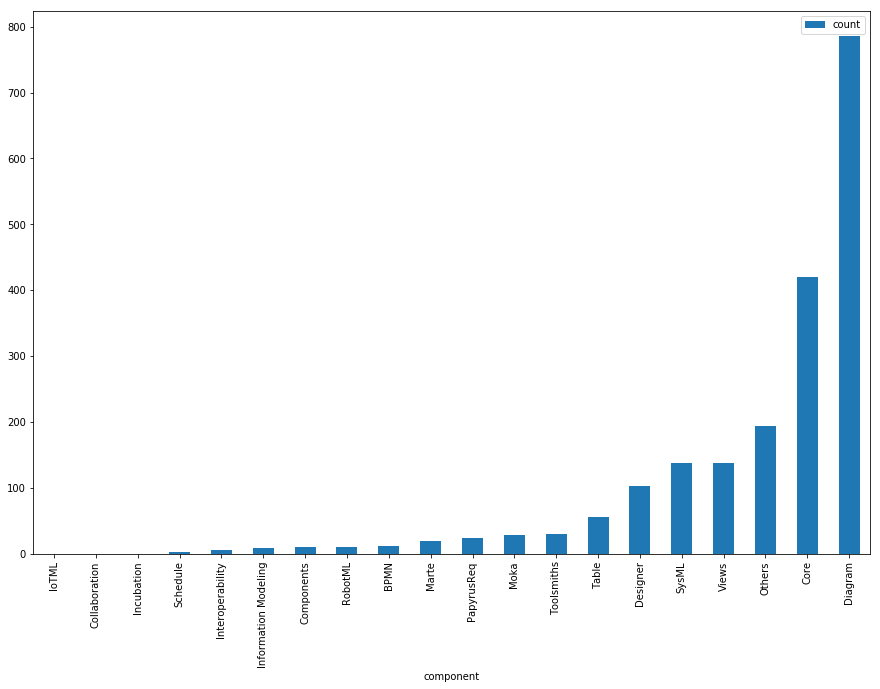

In [3]:
df = pd.DataFrame(dict(id=bug_ids, title=bug_titles, component=bug_components, product=bug_products, 
                       text=bug_text, reporter=bug_reporter, commenters=bug_commenters ))

grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

1.0
83.72
                  count
reporter               
zephod77              1
hardeep3012           1
harazny               1
hanmac                1
gwennole.hinault      1
                    count
reporter                 
johan                  72
give.a.damus           78
ansgar.radermacher     91
vincent.lorenzo       113
francois.le-fevre     160


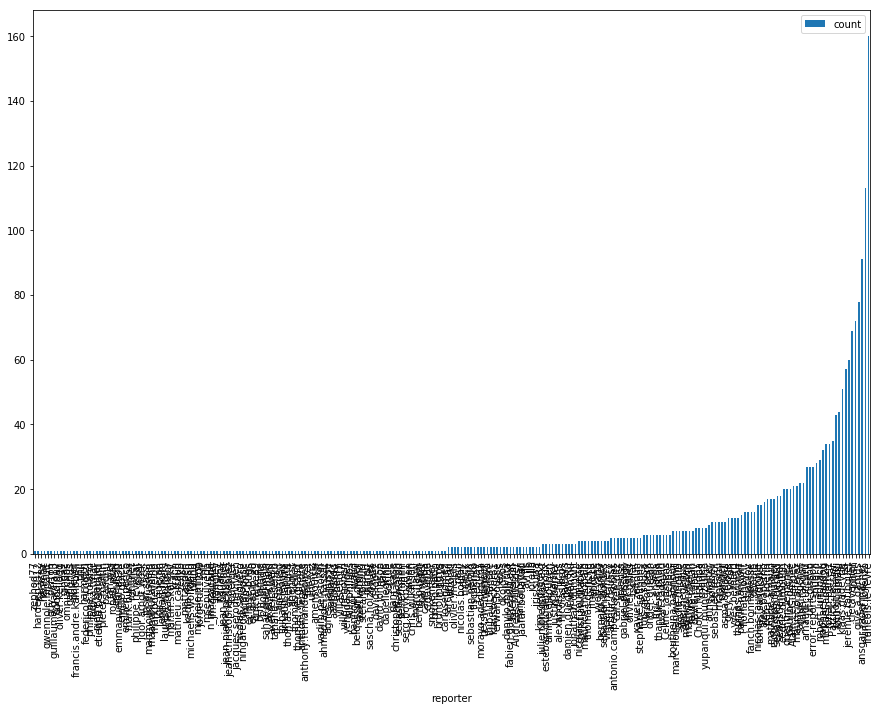

In [4]:
grouped = df.loc[:,['id','reporter']].groupby('reporter').count()
grouped.columns = ['count']
# Find the values bounding the 98 percentile
# May want to filter these later
print(np.percentile(grouped.loc[:,'count'].values, 1))
print(np.percentile(grouped.loc[:,'count'].values, 99))

sorted = grouped.sort_values(by='count')
print(sorted.head())
print(sorted.tail())

sorted.plot(kind='bar', figsize=(15,10))
plt.show()


Accepting values between  145.95  and  36615.71


C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


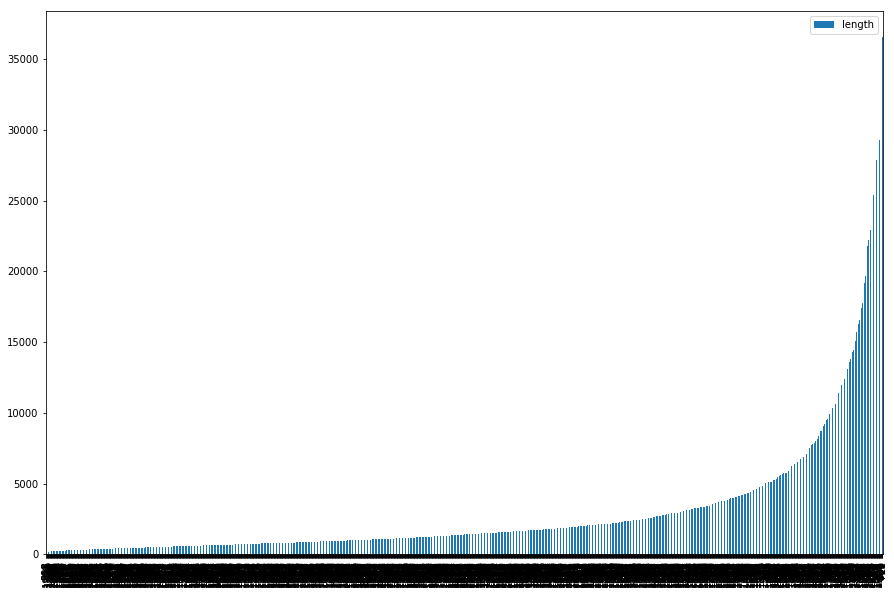

In [18]:
df['length'] = df['text'].str.len()
# Find the values bounding the 98 percentile
# May want to filter these later
one_percent = np.percentile(df.loc[:,'length'].values, 1)
ninety_nine_percent = np.percentile(df.loc[:,'length'].values, 99)
print('Accepting values between ', one_percent, ' and ', ninety_nine_percent)

trimmedDF = df[df['length'] > one_percent][df['length'] < ninety_nine_percent]
trimmedDF.loc[:,['id','length']].sort_values(by='length').plot(kind='bar', figsize=(15,10))

plt.show()

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [59]:
exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text.split(' '):
        if re.fullmatch('[a-zA-Z]+', token):
            filtered_tokens.append(token)
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
    count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
    if count > 20:
        break
print('Total word count: '+str(len(totalvocab)))
    

Total word count: 12067


# Create a TF/IDF Matrix

We'll use the sklearn TfidfVectorizer to build the matrix. For this case, we will use the noun/verb tokenizer to get a list of words from each bug.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.25,
                                   min_df=2,
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize)

#%time tfidf_matrix = tfidf_vectorizer.fit_transform(bug_text) #fit the vectorizer to synopses
%time tfidf_matrix = tfidf_vectorizer.fit_transform(trimmedDF.loc[:,'text']) #fit the vectorizer to synopses
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


Wall time: 15 s


# Create a CountVectorizer


In [65]:
from sklearn.feature_extraction.text import CountVectorizer
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.25, min_df=2, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = tf_vectorizer.get_feature_names()


Wall time: 15 s


In [66]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Run NMF
%time nmf = NMF(n_components=7, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
%time lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

num_words = 5

print('\nNMF Topics: ')
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))

print('\nLDA Topics: ')

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))



Wall time: 182 ms
Wall time: 7.04 s

NMF Topics: 
Topic 0: class element new property attachment
Topic 1: stereotype property label stereotypes display
Topic 2: profile definition applied profiles stereotypes
Topic 3: activity parameter node nodes partition
Topic 4: sysml block uml requirements ibd
Topic 5: association end class owned ends
Topic 6: exception following present error execution

LDA Topics: 
Topic 0: port attachment component new user
Topic 1: activity attachment element uml new
Topic 2: element class use new menu
Topic 3: property stereotype properties profile uml
Topic 4: attachment export copy font linux
Topic 5: state transition region machine pseudo
Topic 6: editor error palette following exception


In [67]:

# predict topics for test data
# unnormalized doc-topic distribution
X_test = tf_vectorizer.transform(trimmedDF.loc[:,'text'].loc[[0]])
doc_topic_dist_unnormalized = np.matrix(lda.transform(X_test))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)
print(doc_topic_dist)
print(doc_topic_dist.argmax(axis=1))
print(trimmedDF.loc[:,'text'].loc[[0]].values)

[[ 0.82341635  0.00178924  0.00179219  0.00178811  0.16762792  0.00178723
   0.00179896]]
[[0]]
[ '[ComponentDiagram] Components-in-component misplaced A component inside a component works fine in the original diagram, but if I place the same components in a new diagram then the inner component gets rendered erroneously: Papyrus places it at delta coordinates relative to canvas orign, but those coordinates were apparently calculated relative to the containing component content space origin.\n\nProcedure:\n- create component L1 in diagram D1\n- create component L2 inside L1\n- create diagram D2\n- d&d L1 into D2\n- L2 cannot be dragged directly into L1, so drag it to the canvas and then into L1. \n- Result: L2 is positioned with the right offset, but relative to canvas origin and not to L1 content area origin.\n\nBug appears in Luna and Mars. New Gerrit change created: https://git.eclipse.org/r/62955 New Gerrit change created: https://git.eclipse.org/r/65164 New Gerrit change created: h

# Create a 2D Visualization

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

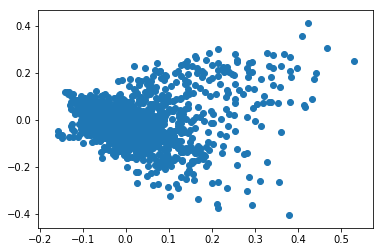

In [68]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tfidf_matrix.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

Wall time: 5min 24s


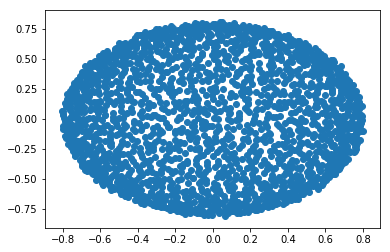

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()
xs, ys = pos[:, 0], pos[:, 1]


# Find Nearest Neighbors

Using the TF/IDF Matrix, find the nearest neighbors for each bug. Print out a random sample with links to spot check. Also plot the distance to the nearest neighbor to visualize the distribution.

Wall time: 1 ms
Distanance to nearest neighbor (Mean/StdDev/Min/Max): (0.98/0.09/0.00/1.00) 


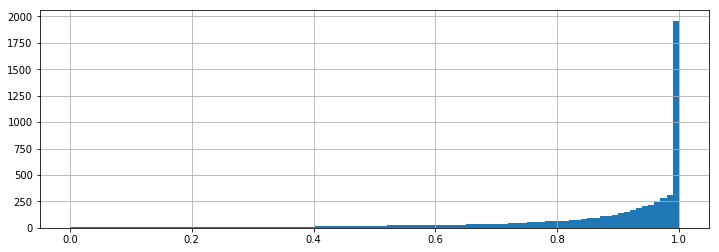

In [86]:
from sklearn.neighbors import NearestNeighbors

%time nbrs = NearestNeighbors().fit(tfidf_matrix)
distances, indices = nbrs.kneighbors(tfidf_matrix)

indicesDF = pd.DataFrame(indices)
sample = indicesDF.sample(5)

# Need to use trimmedDF to properly get bug id
# print('Check the following bugs for relatedness...')
# for row in sample.values:
#     print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[0]]))
#     #print(noun_verb(bug_text[row[0]]))
#     print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[1]]))
#     #print(noun_verb(bug_text[row[1]]))
#     print()
distancesDF = pd.DataFrame(distances)

# Slice the distances returned to get the column of the nearest neighbor
nearest = distancesDF.iloc[:, 1]
print('Distanance to nearest neighbor (Mean/StdDev/Min/Max): (%0.2f/%0.2f/%0.2f/%0.2f) ' % (np.mean(nearest), np.std(nearest),
     np.min(nearest), np.max(nearest)))
nearest.hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [87]:
from sklearn.cluster import KMeans
from sklearn import metrics

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

labels = km.labels_

# May be meaningful if we knew what the labels should be
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
# print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
# print("Adjusted Rand-Index: %.3f"
#       % metrics.adjusted_rand_score(labels, km.labels_))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(tfidf_matrix, km.labels_, sample_size=1000))



Wall time: 12.4 s


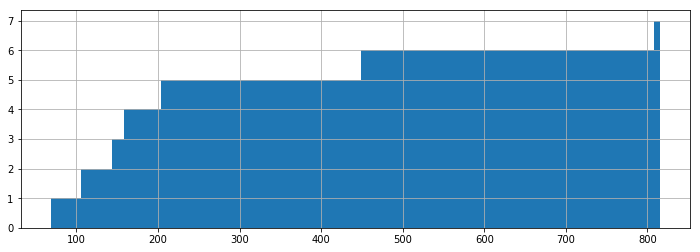

In [81]:
clusters = km.labels_.tolist()
bugs = { 'title': trimmedDF.loc[:,'title'], 'text': trimmedDF.loc[:,'text'], 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [90]:
print("Top term per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

top_term = []
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :1]:
        #print(bug_titles[ind])
        print(terms[ind])
        top_term.append(terms[ind])
        #print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[ind]))
        #top_term.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])


Top term per cluster:

Cluster 0:activity
Cluster 1:element
Cluster 2:stereotype
Cluster 3:package
Cluster 4:sysml
Cluster 5:attachment
Cluster 6:code


C:\Users\n71583\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


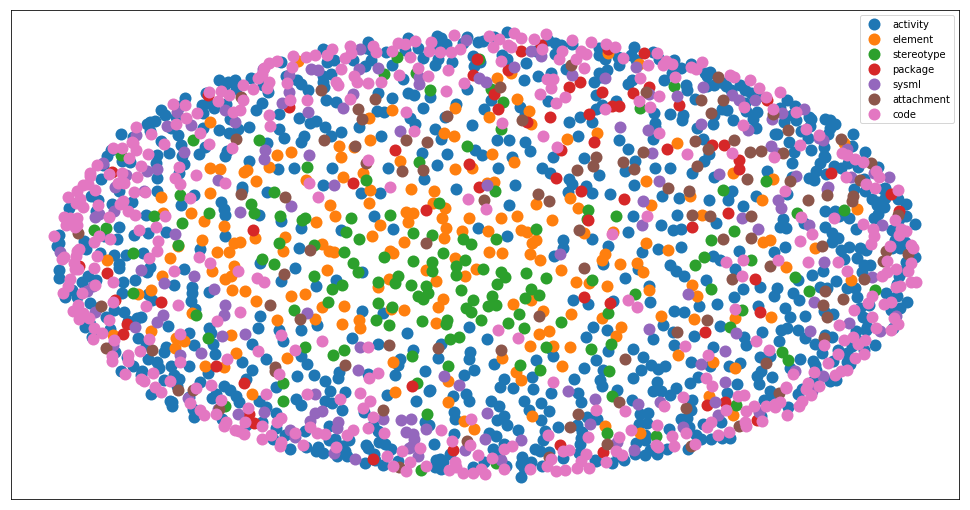

In [91]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'],)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


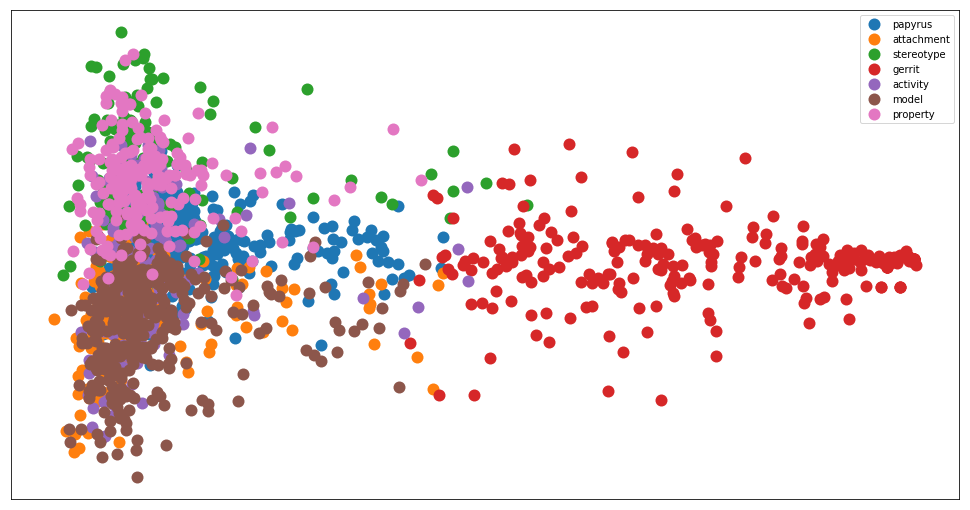

In [25]:
xs, ys = data2D[:, 0], data2D[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


In [74]:
from sklearn.cluster import DBSCAN

# May be able to calculate this number based on the output from the nearest neighbor search.
# Units relate to the data being fit
epsilon = 0.92


db = DBSCAN(eps=epsilon, min_samples=10)

%time db.fit(tfidf_matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % num_clusters)

Wall time: 177 ms
Estimated number of clusters: 1


In [75]:
clusters = db.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

ValueError: Shape of passed values is (2, 2000), indices imply (2, 1960)

In [76]:
xs, ys = pos[:, 0], pos[:, 1]
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
            label=name,
#            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot

ValueError: arrays must all be same length

# Create a Verb/Noun Tokenize Method

This method provides another step of filtering to return only words that are nouns or verbs. We will go ahead and run this against the bugs that we have loaded to find the total number of noun/verbs.


In [58]:
import spacy

nlp = spacy.load('en_core_web_sm')
filter = ['VERB', 'NOUN', 'PROPN']
def noun_verb(text):
    filtered_tokens = []
    doc = nlp(text)
    for sent in doc.sents:
        
        # Bugzilla has a tendency to place inline comments in the form of:
        # > Previous Text
        # This will cause a duplicate if not removed.
        if not re.match('^> ', str(sent)):
            for token in sent:
                if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                    filtered_tokens.append(token.text)
    #    else:
    #        print('>Match')
    return filtered_tokens

# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0
for i in bug_text:
    count = count+1
    allwords = noun_verb(i)
    totalvocab.extend(allwords)
    if count > 20:
        print(count)
        break;
print('Total verb/noun count: '+str(len(totalvocab)))

21
Total verb/noun count: 17325


In [56]:
#Exception
#doc = nlp(bug_text[2])

#Reply
print(bug_ids[19])
print(bug_text[19])
doc = nlp(bug_text[19])
for sent in doc.sents:
    if re.match('^> ', str(sent)):
        print('>Match')
#    print("Sentence->")
#    print(sent)
    if re.match('.+Exception[^\n].*\s+at', str(sent)):
        print('Match!')

508455
Contexts Model Editor error when trying to select datacontext of a view I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is. I have a context file open with the Contexts Model Editor.
I select a view.
When I try to set the datacontexts field of the view the editor show numerous errors messages and freeze.

See attachmment.

Thank you. Hi there is no attachment Created attachment 267197
Screenshot Comment on attachment 267197
Screenshot

Arf sorry, here it is.


NameError: name 'nlp' is not defined

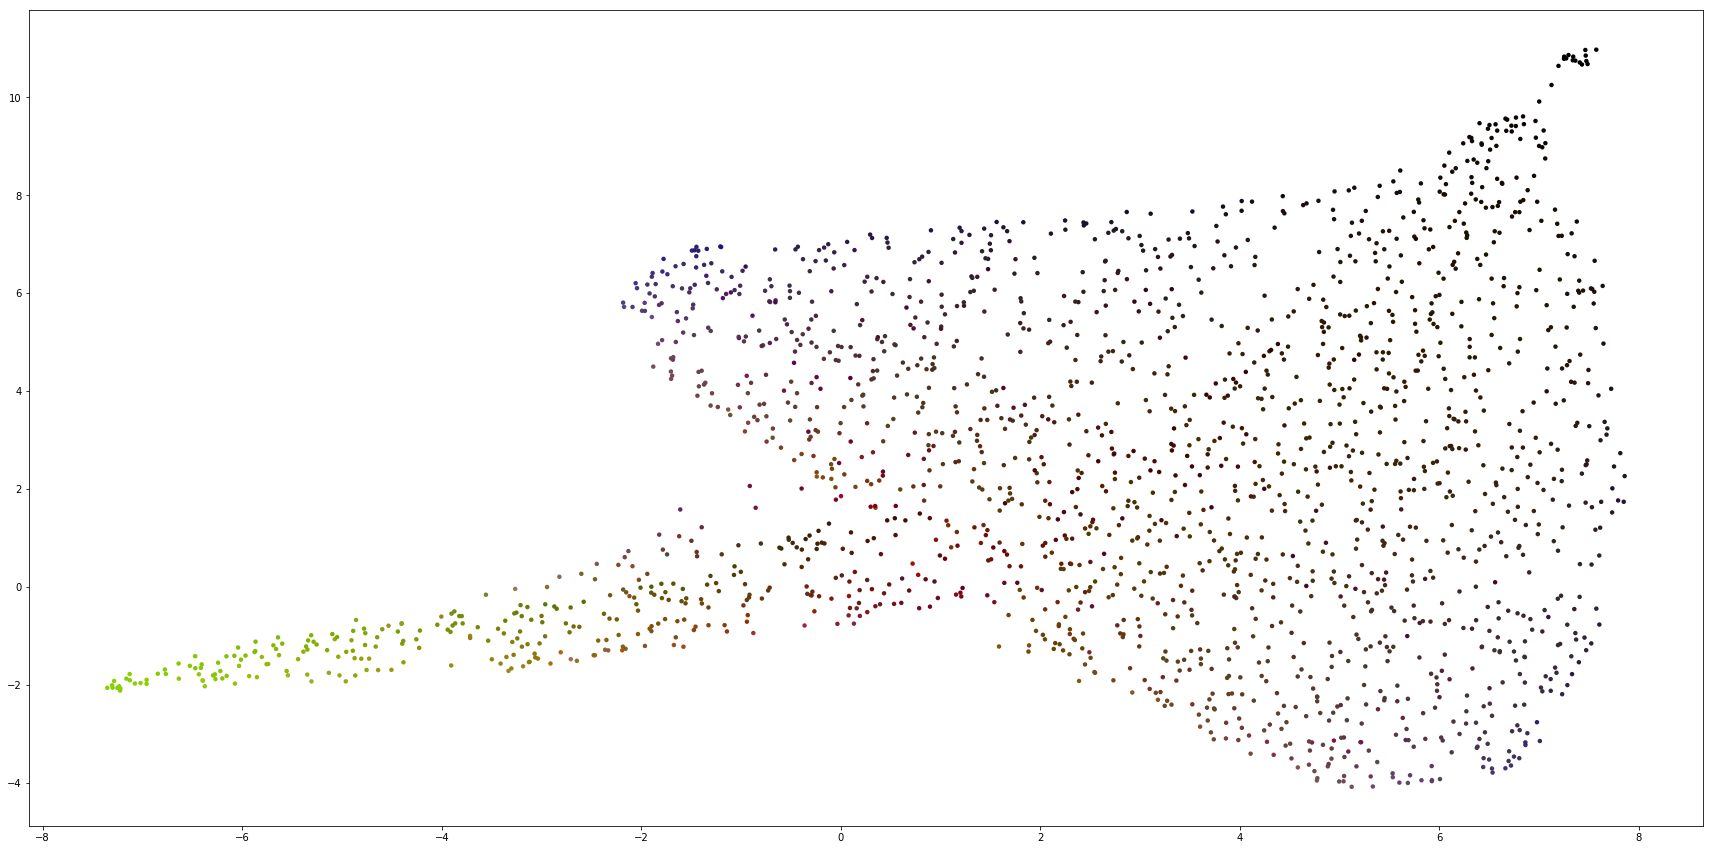

In [54]:
from sklearn.decomposition import TruncatedSVD 
import umap 

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122) 
X_topics = svd_model.fit_transform(tfidf_matrix) 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 

colors = []
for x,y,z in X_topics:
    colors.append((abs(x), abs(y), abs(z)))
    
plt.figure(figsize=(30,15)) 
i = 0;
for em in embedding:
    plt.scatter(em[0], em[1],
        c = colors[i],
        s = 20, # size 
        edgecolor='none' )
    i = i+1
plt.show()